This is a temporary notebook for shap value analysis and plots.

In [1]:
%cd ..

/home/scai/PhenPred


In [2]:
import os
import sys

proj_dir = "/home/scai/PhenPred"
if not os.path.exists(proj_dir):
    proj_dir = "/Users/emanuel/Projects/PhenPred"
sys.path.extend([proj_dir])

import json
import PhenPred
import argparse
import pandas as pd
from PhenPred.vae import plot_folder
from PhenPred.vae.Hypers import Hypers
from PhenPred.vae.Train import CLinesTrain
from PhenPred.vae.DatasetDepMap23Q2 import CLinesDatasetDepMap23Q2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 4
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["figure.figsize"] = (2.5, 2.5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["legend.fontsize"] = 4

sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context(
    "paper",
    rc={
        "axes.linewidth": 0.25,
        "xtick.major.size": 2,
        "xtick.major.width": 0.25,
        "ytick.major.size": 2,
        "ytick.major.width": 0.25,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.labelsize": 7,
        "legend.fontsize": 6,
        "legend.title_fontsize": 6,
    },
)

import matplotlib.patches as mpatches
import umap

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [4]:
import shap
import pickle
from tqdm.notebook import tqdm

In [5]:
TIMESTAMP = "20241210_000556"

In [6]:
hyperparameters = Hypers.read_hyperparameters(timestamp=TIMESTAMP)
clines_db = CLinesDatasetDepMap23Q2(
        labels_names=hyperparameters["labels"],
        datasets=hyperparameters["datasets"],
        feature_miss_rate_thres=hyperparameters["feature_miss_rate_thres"],
        standardize=hyperparameters["standardize"],
        filter_features=hyperparameters["filter_features"],
        filtered_encoder_only=hyperparameters["filtered_encoder_only"],
    )

# ---- Hyperparameters
{
    "activation_function": "prelu",
    "batch_norm": false,
    "batch_size": 256,
    "contrastive_neg_margin": 0.15,
    "contrastive_pos_margin": 0.85,
    "dataname": "depmap23Q2",
    "datasets": {
        "copynumber": "/home/scai/PhenPred/data/clines//cnv_summary_20230303_matrix.csv",
        "crisprcas9": "/home/scai/PhenPred/data/clines//depmap23Q2/CRISPRGeneEffect.csv",
        "drugresponse": "/home/scai/PhenPred/data/clines//drugresponse.csv",
        "metabolomics": "/home/scai/PhenPred/data/clines//metabolomics.csv",
        "methylation": "/home/scai/PhenPred/data/clines//methylation.csv",
        "proteomics": "/home/scai/PhenPred/data/clines//proteomics.csv",
        "transcriptomics": "/home/scai/PhenPred/data/clines//depmap23Q2/OmicsExpressionGenesExpectedCountProfileVoom.csv"
    },
    "dip_vae_type": "i",
    "feature_dropout": 0,
    "feature_miss_rate_thres": 0.85,
    "filter_features": [
        "transcriptomics",
        "crisprcas9"

In [7]:
OMIC_PALLETS = {
    "conditionals": "#4c72b0",
    "copynumber": "#dd8452",
    "drugresponse": "#55a868",
    "metabolomics": "#c44e52",
    "proteomics": "#8172b3",
    "crisprcas9": "#937860",
    "transcriptomics": "#da8bc3",
    "methylation": "#8c8c8c",
}

In [8]:
OMIC_MARKERS = {
    "conditionals": 0,
    "copynumber": 1,
    "drugresponse": 2,
    "metabolomics": 3,
    "proteomics": 4,
    "crisprcas9": 5,
    "transcriptomics": 6,
    "methylation": 7,
}

# Load

In [10]:
shap_values = pickle.load(
    open(f"./reports/vae/files/{TIMESTAMP}_explanation_latent.pkl", "rb")
)

In [38]:
shap_values = shap_values.values

In [20]:
feature_names_all = []
for view_name in clines_db.view_names:
    feature_names_all.append(
        clines_db.features_mask[view_name][
            clines_db.features_mask[view_name] == True
        ].index.values
    )
feature_names_all.append(clines_db.labels_name)
view_names = clines_db.view_names + ["conditionals"]

In [42]:
shap_values[0].shape

(1523, 4922, 200)

In [43]:
all_shap_df = []

# Iterate through each latent dimension (now accessed from the last axis)
for latent_dim in range(shap_values[0].shape[-1]):
    latent_dfs = []

    # Iterate through views (now the first dimension)
    for i in range(len(view_names)):
        view_name = view_names[i]
        feature_names = feature_names_all[i]

        # Access the SHAP values for current view and latent dimension
        # Shape is now [views, samples, features, latent_dim]
        # So we index [i, :, :, latent_dim] to get values for current view and latent dimension
        tmp_df = pd.DataFrame(
            shap_values[i][:, :, latent_dim],
            columns=feature_names,
            index=clines_db.samples,
        )

        # Add view name prefix to column names
        tmp_df.columns = [f"{view_names[i]}_{c}" for c in tmp_df.columns]
        latent_dfs.append(tmp_df)

    # Combine all views for this latent dimension
    latent_dfs = pd.concat(latent_dfs, axis=1)
    latent_dfs["latent_dim"] = f"latent_dim_{latent_dim}"

    all_shap_df.append(latent_dfs)

# Combine all latent dimensions
all_shap_df = pd.concat(all_shap_df, axis=0)

# Reorder columns to put latent_dim first
cols = all_shap_df.columns.tolist()
cols = [cols[-1]] + cols[:-1]
all_shap_df = all_shap_df[cols]
all_shap_df.index.name = "model_id"

In [ ]:
# all_shap_df = []
# for latent_dim in range(len(shap_values)):
#     shap_latent = shap_values[latent_dim]
#     latent_dfs = []
#     for i in range(len(view_names)):
#         view_name = view_names[i]
#         feature_names = feature_names_all[i]
#         tmp_df = pd.DataFrame(shap_latent[i], columns=feature_names, index=clines_db.samples)
#         tmp_df.columns = [f"{view_names[i]}_{c}" for c in tmp_df.columns]
#         latent_dfs.append(tmp_df)
#     latent_dfs = pd.concat(latent_dfs, axis=1)
#     latent_dfs['latent_dim'] = f"latent_dim_{latent_dim}"
    
#     all_shap_df.append(latent_dfs)
# all_shap_df = pd.concat(all_shap_df, axis=0)
# cols = all_shap_df.columns.tolist()
# cols = [cols[-1]] + cols[:-1]
# all_shap_df = all_shap_df[cols]
# all_shap_df.index.name = 'model_id'

In [46]:
all_shap_df = all_shap_df.reset_index()

In [47]:
all_shap_df.shape

(304600, 27854)

In [48]:
all_shap_df.head()

,model_id,latent_dim,proteomics_AAAS,proteomics_AACS,proteomics_AAGAB,proteomics_AAK1,proteomics_AAMDC,proteomics_AAMP,proteomics_AARS1,proteomics_AARS2,proteomics_AARSD1,proteomics_AASDHPPT,proteomics_AASS,proteomics_AATF,proteomics_ABAT,proteomics_ABCB10,proteomics_ABCB6,proteomics_ABCB7,proteomics_ABCC1,proteomics_ABCC3,proteomics_ABCC4,proteomics_ABCD1,proteomics_ABCD3,proteomics_ABCE1,proteomics_ABCF1,proteomics_ABCF2,proteomics_ABCF3,proteomics_ABHD10,proteomics_ABHD11,proteomics_ABHD12,proteomics_ABHD14B,proteomics_ABHD16A,proteomics_ABI1,proteomics_ABI2,proteomics_ABLIM1,proteomics_ABLIM3,proteomics_ABRACL,proteomics_ABRAXAS2,proteomics_ABT1,proteomics_ACAA1,proteomics_ACAA2,proteomics_ACACA,proteomics_ACAD10,proteomics_ACAD8,proteomics_ACAD9,proteomics_ACADM,proteomics_ACADS,proteomics_ACADSB,proteomics_ACADVL,proteomics_ACAP2,...,conditionals_mut_PTPRB,conditionals_mut_PTPRC,conditionals_mut_PTPRK,conditionals_mut_PTPRT,conditionals_mut_QKI,conditionals_mut_RAC1,conditionals_mut_RASA1,conditionals_mut_RASA2,conditionals_mut_RB1,conditionals_mut_RGPD3,conditionals_mut_RGS7,conditionals_mut_RHOA,conditionals_mut_RNF43,conditionals_mut_RNF6,conditionals_mut_RPL22,conditionals_mut_SDHA,conditionals_mut_SETD1B,conditionals_mut_SETD2,conditionals_mut_SMAD4,conditionals_mut_SMARCA4,conditionals_mut_SMARCB1,conditionals_mut_SOX9,conditionals_mut_SPEN,conditionals_mut_STAG2,conditionals_mut_STAT5B,conditionals_mut_STK11,conditionals_mut_TAF15,conditionals_mut_TET1,conditionals_mut_TET2,conditionals_mut_TGFBR2,conditionals_mut_TNC,conditionals_mut_TP53,conditionals_mut_TRIM24,conditionals_mut_TRRAP,conditionals_mut_TSC2,conditionals_mut_UBR5,conditionals_mut_USP8,conditionals_mut_USP9X,conditionals_mut_VHL,conditionals_mut_WNK2,conditionals_mut_WNK4,conditionals_mut_WRN,conditionals_mut_ZEB1,conditionals_mut_ZFHX3,conditionals_mut_ZNF208,conditionals_mut_ZNF429,conditionals_mut_ZNF626,conditionals_mut_ZNF93,conditionals_mut_ZNRF3,conditionals_msi_status
0,SIDM00001,latent_dim_0,-0.000048,0.000026,-0.000059,0.000152,-0.000017,-0.000043,0.000092,-0.000026,-0.000007,-0.000102,0.000070,0.000008,0.000069,-0.000150,0.000191,0.000394,0.000420,0.000031,-0.000008,-0.000047,0.000112,0.000136,0.000363,0.000081,-0.000079,0.000171,-0.000034,-0.000095,0.000240,0.000041,-0.000318,-0.000110,0.000227,-0.000002,-0.000001,0.000132,0.000132,0.000050,0.000014,0.000164,0.000247,-0.000138,0.000012,0.000321,0.000420,-0.000012,-0.000015,0.000417,...,0.000007,0.000082,0.000000,0.000092,-9.507989e-07,-0.000172,0.000061,0.000000,0.000000,0.000000,0.000000,0.000242,0.000146,0.000000,0.000223,-0.000920,-0.00019,0.000000,0.000033,0.000214,0.000000,0.000081,0.000101,-0.000122,0.00000,0.000174,0.000000,0.000000,0.000000,0.000108,0.000000,0.008310,0.000000,0.000000,0.000000e+00,0.000000,-0.000105,0.000000,-0.000381,0.000000,0.000000,0.000000,0.000188,0.000676,0.000000,-0.000098,0.000036,0.000041,0.0,0.0
1,SIDM00003,latent_dim_0,-0.000099,0.000012,-0.000063,0.000198,0.000093,-0.000081,0.000063,0.000105,0.000053,-0.000011,-0.000022,0.000049,-0.000095,0.000089,-0.000024,0.000007,0.000047,-0.000011,-0.000111,-0.000235,0.000165,0.000004,0.000152,0.000153,-0.000223,-0.000241,0.000010,0.000256,-0.000120,0.000020,-0.000408,0.000007,-0.000112,-0.000154,-0.000334,0.000199,0.000018,-0.000113,-0.000279,0.000515,0.000282,-0.000122,0.000013,-0.000620,-0.000198,0.000077,-0.000343,0.000090,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000187,0.000000,0.000479,0.000000,-0.000090,0.000645,0.000000,0.000093,0.000300,-0.000601,0.00000,-0.000684,0.000000,0.000000,0.000216,0.000067,0.000068,-0.000095,0.00000,0.000000,0.000190,0.000000,0.000000,0.000426,0.000000,0.005435,0.000000,-0.000089,-7.063922e-06,0.000000,0.000000,0.000000,-0.000438,0.000000,0.000064,0.000000,0.000000,-0.012666,-0.000008,0.000000,0.000000,0.000184,0.0,0.0
2,SIDM00005,latent_dim_0,-0.000034,-0.000008,0.000104,0.000204,0.000032,-0.000009,-0.000014,0.000099,0.000013,-0.000033,0.000029,-0.000014

In [49]:
all_shap_df.iloc[:, 2:] = all_shap_df.iloc[:, 2:].abs()

# aggregate latent

In [50]:
shap_latent_sum_df = all_shap_df.drop(columns=['latent_dim']).groupby('model_id').sum()

In [51]:
shap_latent_sum_df.to_csv(
    f"./reports/vae/files/{TIMESTAMP}_latent_shap_values_df_sum.csv.gz", compression="gzip"
)

In [11]:
shap_latent_sum_df = pd.read_csv(
    f"./reports/vae/files/{TIMESTAMP}_latent_shap_values_df_sum.csv.gz", compression="gzip", index_col=0
)

In [52]:
global_feature_importance_df = (
    shap_latent_sum_df.mean()
    .sort_values(ascending=False)
    .reset_index(name="importance")
)
global_feature_importance_df.rename(columns={"index": "feature"}, inplace=True)

In [53]:
global_feature_importance_df.to_csv(
    f"./reports/vae/files/{TIMESTAMP}_latent_shap_values_df_sum_global.csv", index=False
)

In [14]:
global_feature_importance_df = pd.read_csv(
    f"./reports/vae/files/{TIMESTAMP}_latent_shap_values_df_sum_global.csv"
)

In [54]:
global_feature_importance_df.head(10)

,feature,importance
0,copynumber_RSPH10B2,2.927180
1,copynumber_CDKN2A,1.216689
2,copynumber_PMS2,1.207333
3,conditionals_day4_day1_ratio,1.181447
4,copynumber_ZMYM2,1.164136
5,conditionals_mut_TP53,1.140086
6,conditionals_tissue_Haematopoietic and Lymphoid,1.126392
7,copynumber_NBEA,1.092891
8,copynumber_UGT2B17,0.953780
9,copynumber_NFIB,0.916468


In [11]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("metabolom")
].head(10)

,feature,importance,omic_layer
23,metabolomics_1-methylnicotinamide,1.269368,metabolomics
25,metabolomics_C52:2 TAG,1.252069,metabolomics
26,metabolomics_C52:3 TAG,1.250422,metabolomics
30,metabolomics_C50:2 TAG,1.195308,metabolomics
31,metabolomics_C54:3 TAG,1.188903,metabolomics
38,metabolomics_C16:1 SM,1.144335,metabolomics
41,metabolomics_C48:2 TAG,1.110043,metabolomics
51,metabolomics_C50:1 TAG,1.063773,metabolomics
52,metabolomics_C14:0 SM,1.056895,metabolomics
53,metabolomics_C54:4 TAG,1.056064,metabolomics


In [56]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("conditionals")
].head(10)

,feature,importance
3,conditionals_day4_day1_ratio,1.181447
5,conditionals_mut_TP53,1.140086
6,conditionals_tissue_Haematopoietic and Lymphoid,1.126392
14,conditionals_tissue_Lung,0.821399
800,conditionals_doubling_time_hours,0.327485
838,conditionals_tissue_Skin,0.320393
1975,conditionals_mut_KMT2C,0.251876
2180,conditionals_tissue_Central Nervous System,0.247180
3698,conditionals_mut_KRAS,0.223838
5268,conditionals_mut_SDHA,0.206595


In [57]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("transcriptomics")
].head(10)

,feature,importance
787,transcriptomics_CDKN2A,0.330626
1019,transcriptomics_USP9Y,0.297834
1148,transcriptomics_CDKN2B,0.285237
1154,transcriptomics_C5,0.284975
1180,transcriptomics_M1AP,0.283337
1297,transcriptomics_PWP2,0.276248
1299,transcriptomics_LPCAT1,0.276126
1308,transcriptomics_GATD3A,0.275667
1386,transcriptomics_SCARB1,0.271782
1419,transcriptomics_RPS27L,0.270263


In [14]:
rna_importance_df = global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("transcriptomics")
].reset_index(drop=True)
rna_importance_df[rna_importance_df["feature"].str.contains("NNMT")]

,feature,importance,omic_layer
4431,transcriptomics_NNMT,0.346385,transcriptomics


In [15]:
rna_importance_df.shape

(8078, 3)

In [16]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("copynumbercas9")
].head(20)

,feature,importance,omic_layer


In [58]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("proteomics")
].head(20)

,feature,importance
738,proteomics_HBA1,0.340855
908,proteomics_PRKDC,0.310210
921,proteomics_RPL37A,0.308294
955,proteomics_GCDH,0.304455
969,proteomics_BANF1,0.303244
1025,proteomics_NUP62,0.297157
1066,proteomics_GCLM,0.293002
1089,proteomics_DCXR,0.290456
1170,proteomics_RBM3,0.283758
1176,proteomics_PRPF4B,0.283572


In [18]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("methylation")
].head(20)

,feature,importance,omic_layer
13587,methylation_FOXD4L3,0.333646,methylation
13969,methylation_UCK1,0.327589,methylation
14849,methylation_SNORA81,0.313605,methylation
14850,methylation_MIR1248,0.313605,methylation
15076,methylation_ADHFE1,0.309721,methylation
15081,methylation_SNORA63,0.309627,methylation
15320,methylation_CCHCR1,0.305029,methylation
15478,methylation_NFKBID,0.301979,methylation
15693,methylation_INTS4L2,0.297477,methylation
15767,methylation_BOLA2B,0.295996,methylation


In [19]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.startswith("methylation")
].head(20)

,feature,importance,omic_layer
13587,methylation_FOXD4L3,0.333646,methylation
13969,methylation_UCK1,0.327589,methylation
14849,methylation_SNORA81,0.313605,methylation
14850,methylation_MIR1248,0.313605,methylation
15076,methylation_ADHFE1,0.309721,methylation
15081,methylation_SNORA63,0.309627,methylation
15320,methylation_CCHCR1,0.305029,methylation
15478,methylation_NFKBID,0.301979,methylation
15693,methylation_INTS4L2,0.297477,methylation
15767,methylation_BOLA2B,0.295996,methylation


In [59]:
global_feature_importance_df["omic_layer"] = global_feature_importance_df[
    "feature"
].map(lambda x: x.split("_")[0])

In [60]:
df_sorted = global_feature_importance_df.sort_values(
    ["omic_layer", "importance"], ascending=[True, False]
)

In [61]:
df_sorted['feature'] = df_sorted['feature'].map(lambda x: "_".join(x.split("_")[1:]))
df_sorted.head()

,feature,importance,omic_layer
3,day4_day1_ratio,1.181447,conditionals
5,mut_TP53,1.140086,conditionals
6,tissue_Haematopoietic and Lymphoid,1.126392,conditionals
14,tissue_Lung,0.821399,conditionals
800,doubling_time_hours,0.327485,conditionals


In [62]:
df_sorted_no_tag = df_sorted[~df_sorted["feature"].str.contains(" TAG")]

In [63]:
df_top10_no_tag = df_sorted_no_tag.groupby("omic_layer").head(10)

In [64]:
df_top5 = df_sorted.groupby('omic_layer').head(5).reset_index(drop=True)
df_top2 = df_sorted.groupby('omic_layer').head(2).reset_index(drop=True)
df_top1 = df_sorted.groupby('omic_layer').head(1).reset_index(drop=True)

In [65]:
# Calculate the mean importance for each omic_layer
mean_importance = df_top2.groupby("omic_layer")["importance"].mean().reset_index()

# Sort omic_layer by mean importance
mean_importance_sorted = mean_importance.sort_values("importance", ascending=False)

# Reorder DataFrame based on the sorted omic_layers
df_top2["omic_layer"] = pd.Categorical(
    df_top2["omic_layer"], categories=mean_importance_sorted["omic_layer"], ordered=True
)
df_top2 = df_top2.sort_values(
    ["omic_layer", "importance"], ascending=[True, False]
).reset_index(drop=True)

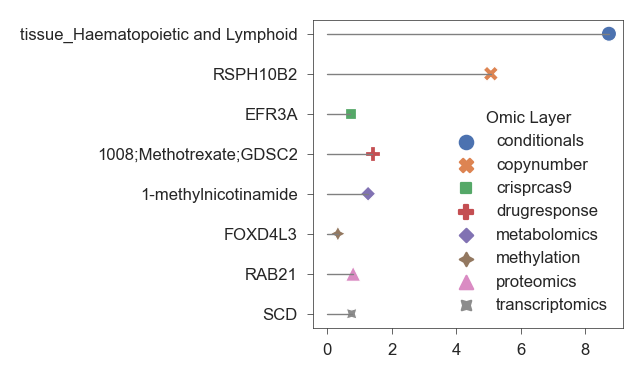

In [24]:
plt.figure(figsize=(2,2))

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=df_top1,
    y="feature",
    x="importance",
    hue="omic_layer",
    style="omic_layer",
    s=30,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top1.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

plt.ylabel("")
plt.xlabel("")
plt.legend(title="Omic Layer")
plt.show()

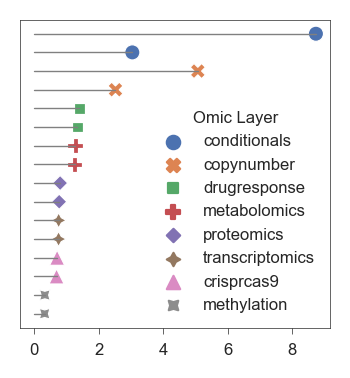

In [25]:
plt.figure(figsize=(2,2))

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=df_top2,
    y="feature",
    x="importance",
    hue="omic_layer",
    style="omic_layer",
    s=30,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top2.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

plt.ylabel("")
plt.xlabel("")
plt.yticks([],fontsize=8)
plt.legend(title="Omic Layer")
# plt.show()
plt.savefig(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top2.pdf")

In [66]:
# Calculate the mean importance for each omic_layer
mean_importance = df_top5.groupby("omic_layer")["importance"].mean().reset_index()

# Sort omic_layer by mean importance
mean_importance_sorted = mean_importance.sort_values("importance", ascending=False)

# Reorder DataFrame based on the sorted omic_layers
df_top5["omic_layer"] = pd.Categorical(
    df_top5["omic_layer"], categories=mean_importance_sorted["omic_layer"], ordered=True
)
df_top5 = df_top5.sort_values(
    ["omic_layer", "importance"], ascending=[True, False]
).reset_index(drop=True)

In [67]:
list(mean_importance_sorted["omic_layer"])

['copynumber',
 'conditionals',
 'drugresponse',
 'metabolomics',
 'crisprcas9',
 'proteomics',
 'transcriptomics',
 'methylation']

In [33]:
df_top10_no_tag.to_csv(
    f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top10_no_tag.csv",
    index=False,
)

In [31]:
df_top5.to_csv(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5.csv", index=False)

In [ ]:
df_top5 = pd.read_csv(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5.csv")

In [69]:
df_top5_part1 = df_top5[
    df_top5["omic_layer"]
    .isin(["conditionals", "drugresponse", "copynumber", "metabolomics"])
    .reset_index(drop=True)
]
df_top5_part2 = df_top5[
    ~df_top5["omic_layer"]
    .isin(["conditionals", "drugresponse", "copynumber", "metabolomics"])
    .reset_index(drop=True)
]

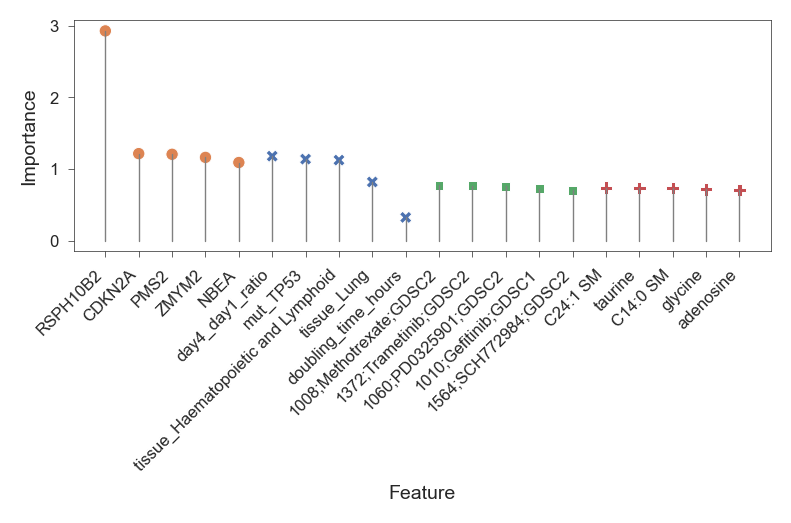

In [70]:
plt.figure(figsize=(4.5, 1.5))

# Create a categorical scatter plot and set marker style and size
g = sns.scatterplot(
    data=df_top5_part1,
    x="feature",
    y="importance",
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part1.iterrows():
    plt.plot([row["feature"], row["feature"]], [0, row["importance"]], "grey", lw=0.5)

plt.xticks(rotation=45, ha="right")

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.legend(title="Omic Layer").remove()
# plt.show()
# plt.tight_layout()
plt.savefig(
    f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5_part1_h.pdf",
    bbox_inches="tight",
)

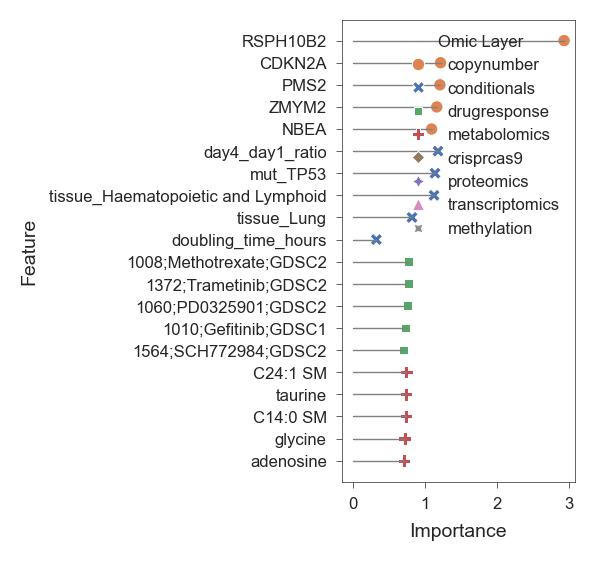

In [71]:
plt.figure(figsize=(1.5, 3))

# Create a categorical scatter plot and set marker style and size
g = sns.scatterplot(
    data=df_top5_part1,
    y="feature",
    x="importance",
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part1.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

# plt.title("Top 5 Features from Each Omic Layer by Importance")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.legend(title="Omic Layer")
# plt.show()
# plt.tight_layout()
plt.savefig(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5_part1.pdf")

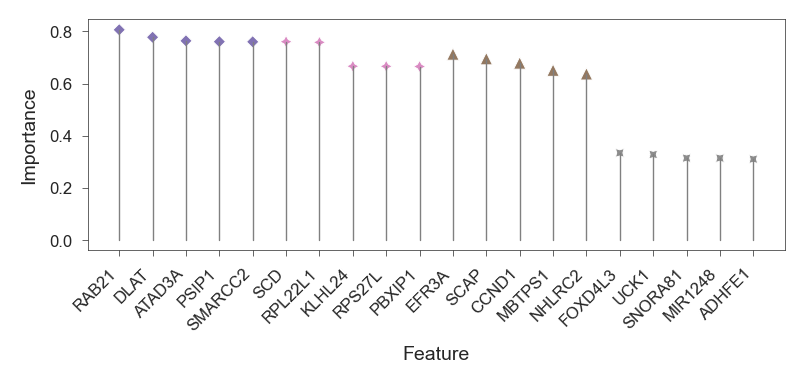

In [34]:
plt.figure(figsize=(4.5, 1.5))

# Create a categorical scatter plot and set marker style and size
g = sns.scatterplot(
    data=df_top5_part2,
    x="feature",
    y="importance",
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part2.iterrows():
    plt.plot([row["feature"], row["feature"]], [0, row["importance"]], "grey", lw=0.5)

plt.xticks(rotation=45, ha="right")

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.legend(title="Omic Layer").remove()
# plt.show()
# plt.tight_layout()
plt.savefig(
    f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5_part2_h.pdf",
    bbox_inches="tight",
)

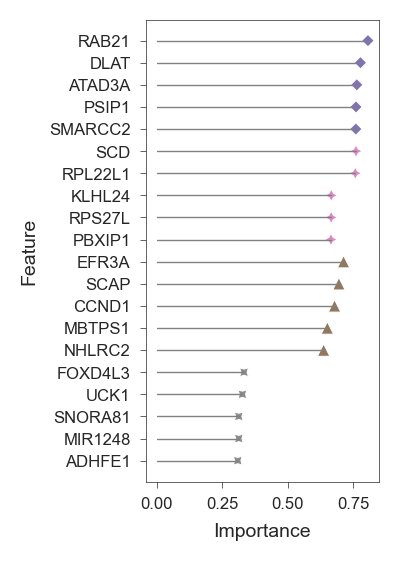

In [29]:
plt.figure(figsize=(1.5, 3))

# Create a categorical scatter plot and set marker style and size
sns.scatterplot(
    data=df_top5_part2,
    y="feature",
    x="importance",
    hue="omic_layer",
    palette=OMIC_PALLETS,
    style="omic_layer",
    s=20,
)

# Draw lines connecting each point to the y-axis
for _, row in df_top5_part2.iterrows():
    plt.plot([0, row["importance"]], [row["feature"], row["feature"]], "grey", lw=0.5)

# plt.title("Top 5 Features from Each Omic Layer by Importance")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.legend(title="Omic Layer").remove()
plt.savefig(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_top5_part2.pdf")

In [56]:
global_feature_importance_df.groupby("omic_layer")[["importance"]].mean().sort_values(
    "importance", ascending=False
)

,importance
omic_layer,
metabolomics,0.638349
copynumber,0.483749
drugresponse,0.477286
crisprcas9,0.413631
transcriptomics,0.356984
proteomics,0.316226
conditionals,0.175110
methylation,0.156285


In [77]:
global_feature_importance_omic_summary_df = pd.merge(
    global_feature_importance_df.groupby("omic_layer")[["importance"]]
    .mean()
    .sort_values("importance", ascending=False)
    .reset_index(),
    global_feature_importance_df.groupby("omic_layer")
    .size()
    .reset_index(name="feature_count"),
    on="omic_layer",
)

In [78]:
global_feature_importance_omic_summary_df

,omic_layer,importance,feature_count
0,metabolomics,0.394204,225
1,copynumber,0.343448,777
2,drugresponse,0.285795,810
3,crisprcas9,0.212119,5213
4,transcriptomics,0.143757,8078
5,proteomics,0.126493,4922
6,methylation,0.086297,7590
7,conditionals,0.059727,237


In [59]:
global_feature_importance_df.to_csv(
    f"./reports/vae/files/{TIMESTAMP}_latent_shap_values_df_sum_global.csv", index=False
)

In [74]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.contains("metabolomics_1-")
]

,feature,importance,omic_layer
101,metabolomics_1-methylnicotinamide,0.573762,metabolomics


In [75]:
global_feature_importance_df[
    global_feature_importance_df["feature"].str.contains("SMAD4")
]

,feature,importance,omic_layer
389,copynumber_SMAD4,0.425694,copynumber
4742,crisprcas9_SMAD4,0.211849,crisprcas9
18367,transcriptomics_SMAD4,0.106632,transcriptomics
18893,proteomics_SMAD4,0.103112,proteomics
24844,conditionals_mut_SMAD4,0.066022,conditionals


In [79]:
global_feature_importance_omic_summary_df["omic_layer"].tolist()

['metabolomics',
 'copynumber',
 'drugresponse',
 'crisprcas9',
 'transcriptomics',
 'proteomics',
 'methylation',
 'conditionals']

In [63]:
global_feature_importance_df.groupby("omic_layer")[["importance"]].sum()

,importance
omic_layer,
conditionals,41.501134
copynumber,375.873147
crisprcas9,2156.257968
drugresponse,386.601644
metabolomics,143.628547
methylation,1186.206485
proteomics,1556.466352
transcriptomics,2883.715463


<Axes: xlabel='importance', ylabel='omic_layer'>

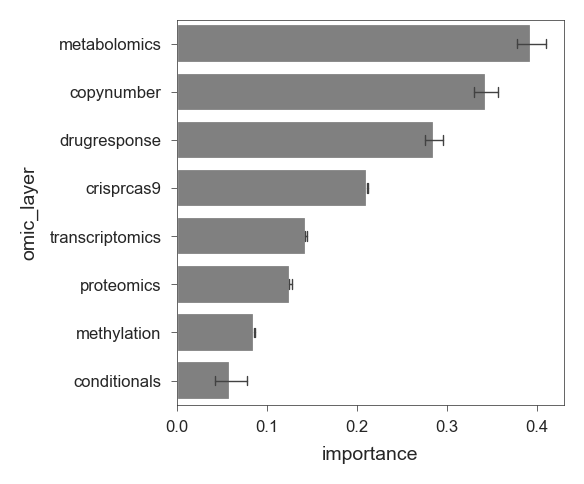

In [80]:
sns.barplot(
    x="importance",
    y="omic_layer",
    data=global_feature_importance_df,
    errwidth=0.5,
    ci=95,
    capsize=0.2,
    order=global_feature_importance_omic_summary_df["omic_layer"].tolist(),
    # palette=OMIC_PALLETS
    color='grey'
)
# plt.savefig(f"./reports/vae/latent/{TIMESTAMP}_latent_shap_omic_ranking.pdf")

In [108]:
for omic in global_feature_importance_omic_summary_df["omic_layer"].tolist():
    feature_df = global_feature_importance_df[
        global_feature_importance_df["omic_layer"] == omic
    ]
    feature_df["feature"] = feature_df["feature"].map(lambda x: x.split("_")[1])
    feature_df[["feature", "importance"]].to_csv(
        f"./reports/vae/files/{TIMESTAMP}_shap_values_{omic}_for_gsea.csv",
        index=False,
    )